In [1]:
!pip install wandb -q

## Import Require Libraries

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import models, transforms
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from timeit import default_timer as timer

In [3]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

In [4]:
import wandb

API_KEY = '881252af31786a1cf813449b9b4124955f54703e'

wandb.login(key=API_KEY)
print("[LOG]: Login Succesfull.")

wandb: Currently logged in as: jashpatel8561 (maa_64). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[LOG]: Login Succesfull.


## Device agnostic code

In [5]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [6]:
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
                              ])

aug_trasform = transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.RandomRotation(15),
                                   transforms.RandomCrop(10),
                                   transforms.ToTensor()
                                  ])

In [7]:
train_dataset = datasets.FashionMNIST(root = '/data', train = True, transform = transform, download = True)
aug_train_dataset = datasets.FashionMNIST(root = '/data', train = True, transform = aug_trasform, download = True)
test_dataset = datasets.FashionMNIST(root = '/data', train = False, transform = transform, download = True)

## get only odd classes

In [8]:
train_list = []
train_aug_list = []
test_list = []


for i, (x,y) in enumerate(train_dataset):
  if y % 2 != 0:
    train_list.append(train_dataset[i])
  # print(train_data[i])
  # break

# for i, (x,y) in enumerate(aug_train_dataset):
#   if y % 2 != 0:
#     train_aug_list.append(train_dataset[i])

for x,y in test_dataset:
  if y % 2 != 0:
    test_list.append((x, y))

len(train_list), len(test_list), len(train_aug_list)

(30000, 5000, 0)

In [9]:
# concate datasets
# new_train_data = torch.utils.data.ConcatDataset((train_list, train_aug_list))
new_train_data = torch.utils.data.ConcatDataset([train_list])
new_test_data = torch.utils.data.ConcatDataset([test_list])

In [10]:
len(new_train_data), len(new_test_data)

(30000, 5000)

## Make dataloader

In [11]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = new_train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = new_test_data, batch_size = BATCH_SIZE, shuffle = False)

In [12]:
print(f'Total {len(train_dataloader)} of train each of {BATCH_SIZE} batches.')
print(f'Total {len(test_dataloader)} of test each of {BATCH_SIZE} batches.')

Total 938 of train each of 32 batches.
Total 157 of test each of 32 batches.


In [13]:
# class name
class_names = [train_dataset.classes[i] for i in range(len(train_dataset.classes)) if i % 2 != 0] 
class_names

['Trouser', 'Dress', 'Sandal', 'Sneaker', 'Ankle boot']

In [14]:
index_cls = train_dataset.class_to_idx
index_cls

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [15]:
for i, (x,y) in enumerate(train_dataloader):
  print(y)
  break

tensor([7, 3, 7, 5, 1, 3, 9, 5, 7, 1, 3, 3, 1, 3, 9, 3, 9, 3, 5, 1, 7, 9, 5, 9,
        3, 3, 9, 5, 9, 7, 9, 1])


Image: torch.Size([1, 32, 32])


Text(0.5, 1.0, 'Ankle boot')

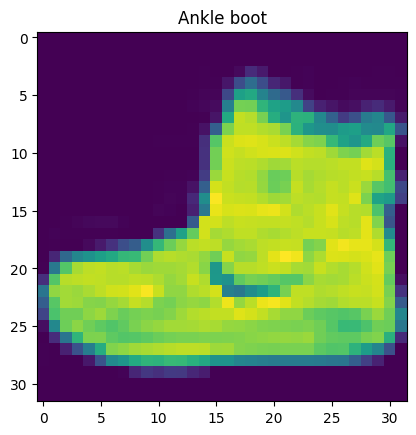

In [16]:
image, label = new_train_data[0]
print(f"Image: {image.shape}")
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label//2])
# image

## Train and test loop

In [17]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (x_train, y_train) in enumerate(dataloader):

    Y = []
    for i in y_train:
      if i.item() % 2 == 0:
        Y.append((i.item()//2)+1)
      else:
        Y.append(i.item()//2)
    
    y_train = torch.tensor(Y)
    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)
    

    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print(torch.argmax(pred, dim=1))
    
    # print(y_train)

    # print(torch.argmax(pred, dim=0))
    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      Y = []
      for i in y_test:
        if i.item() % 2 == 0:
          Y.append((i.item()//2)+1)
        else:
          Y.append(i.item()//2)
      
      y_test = torch.tensor(Y)
      
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))


    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Plot Function

In [18]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## Loss and Accuracy Function

In [19]:
loss_fn = nn.CrossEntropyLoss()

accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

## set activation function

In [20]:
# def funct(list_mods):
#   # print("type: ", type(list_mods))
#   for i in range(len(list_mods)):
#     if list_mods[i].__class__.__name__ == "ReLU":
#       list_mods[i] = nn.Tanh()
#     elif list_mods[i].__class__.__name__ in ("Sequential", "BasicBlock"):
#       list_mods[i] = nn.Sequential(*funct(list(list_mods[i].children())))
#   return list_mods

## Load model

In [21]:
model_18 = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1, progress = False).to(device)
model_18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
feature_number = model_18.fc.in_features
model_18.fc = nn.Linear(feature_number, len(class_names)).to(device)

model_18

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
activation_function = ['Tanh', 'RELU']
# optimizer_1 = ("Adam", torch.optim.Adam(params = model_18.parameters(), lr = 1e-3))
# optimizer_2 = ("SGD", torch.optim.SGD(params = model_18.parameters(), lr = 1e-2))

optimizer = ["Adam", "SGD"]

# resnet18_selu = nn.Sequential(*funct(list(model_18.children()))).to(device)
# resnet18_selu

## Hyper Parameters

In [23]:
hyper_para = [(activation, opti) for activation in activation_function for opti in optimizer]

## Helper function

In [24]:
def validate_model(model, valid_dl, loss_fn, accuracy_fn, log_images=False, batch_idx=0, device: torch.device = device):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss, val_acc = 0, 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)



            Y = []
            for i in labels:
              if i.item() % 2 == 0:
                Y.append((i.item()//2)+1)
              else:
                Y.append(i.item()//2)
            
            labels = torch.tensor(Y)

            if device == 'cuda':
              images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            # val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            val_loss += loss_fn(outputs, labels)
            val_acc += accuracy_fn(labels, torch.argmax(outputs, dim=1))

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, torch.max(outputs.data, 1), labels, outputs.softmax(dim=1))

        val_loss /= len(test_dataloader)
        val_acc /= len(test_dataloader)
    return val_loss, val_acc

def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

## train model with wandb

Current iter: 1/4
Activation function: Tanh and Optimizer: Adam



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.2047 | Test Loss: 0.1082 | Train Accuray: 0.9314 | Test Accuracy: 0.9608

Epoch: 2
Train Loss: 0.1239 | Test Loss: 0.0968 | Train Accuray: 0.9575 | Test Accuracy: 0.9655

Epoch: 3
Train Loss: 0.0920 | Test Loss: 0.0981 | Train Accuray: 0.9679 | Test Accuracy: 0.9629

Epoch: 4
Train Loss: 0.1050 | Test Loss: 0.0986 | Train Accuray: 0.9658 | Test Accuracy: 0.9650

Epoch: 5
Train Loss: 0.0787 | Test Loss: 0.1256 | Train Accuray: 0.9724 | Test Accuracy: 0.9591

Epoch: 6
Train Loss: 0.0695 | Test Loss: 0.0949 | Train Accuray: 0.9765 | Test Accuracy: 0.9677

Epoch: 7
Train Loss: 0.0637 | Test Loss: 0.0686 | Train Accuray: 0.9770 | Test Accuracy: 0.9769

Epoch: 8
Train Loss: 0.0564 | Test Loss: 0.0749 | Train Accuray: 0.9794 | Test Accuracy: 0.9739

Epoch: 9
Train Loss: 0.0503 | Test Loss: 0.0647 | Train Accuray: 0.9828 | Test Accuracy: 0.9780

Epoch: 10
Train Loss: 0.0502 | Test Loss: 0.0535 | Train Accuray: 0.9819 | Test Accuracy: 0.9781

Epoch: 11
Train Loss: 0.0598 

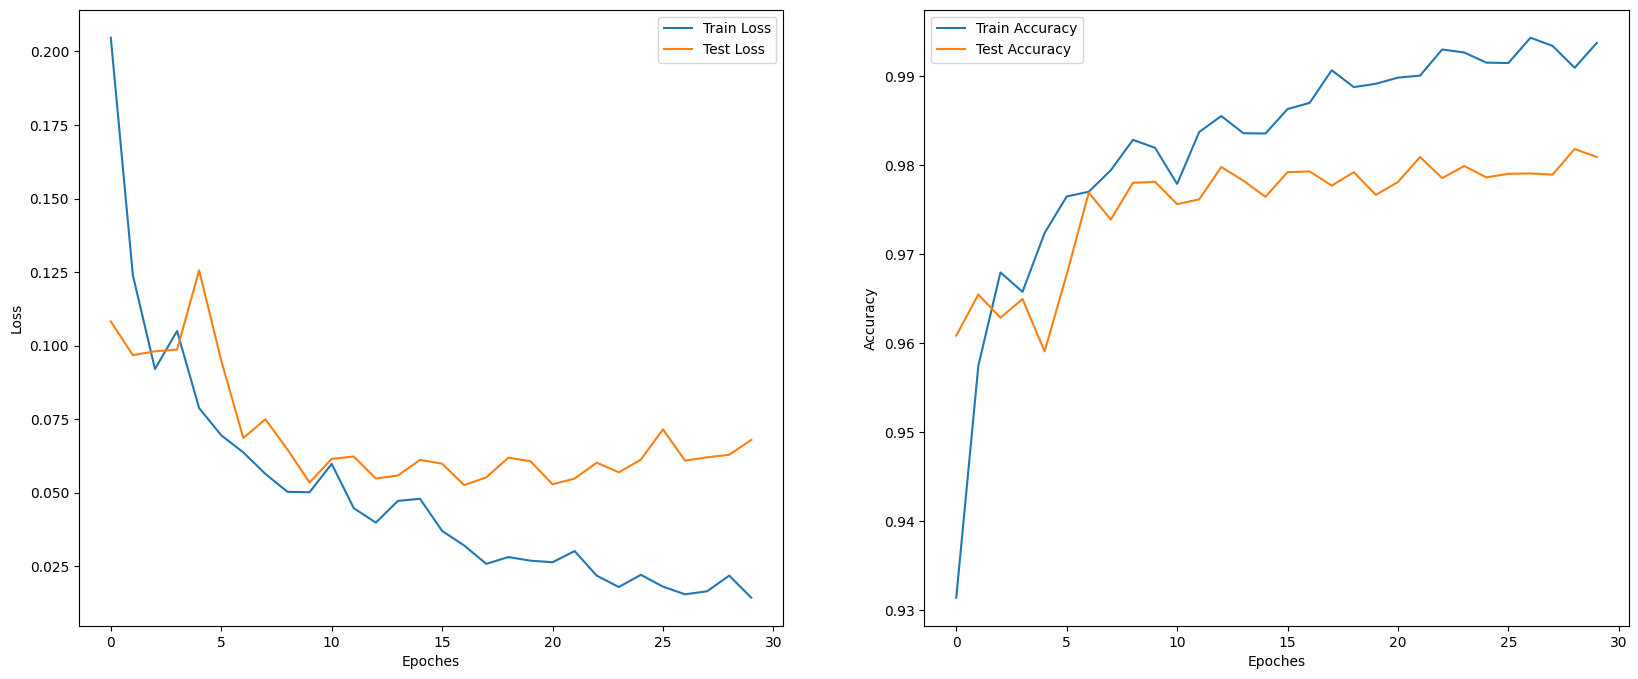

Execution time of 1 iter: 491.2617652910001 Seconds.


Train Accuracy,▁
Train Loss,▁
Validation Accuracy,▁
Validation Loss,▁
Train Accuracy,0.99371
Train Loss,0.01428
Validation Accuracy,0.9809
Validation Loss,0.06795


Current iter: 2/4
Activation function: Tanh and Optimizer: SGD



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.2006 | Test Loss: 0.1032 | Train Accuray: 0.9280 | Test Accuracy: 0.9613

Epoch: 2
Train Loss: 0.0999 | Test Loss: 0.0925 | Train Accuray: 0.9614 | Test Accuracy: 0.9671

Epoch: 3
Train Loss: 0.0743 | Test Loss: 0.0830 | Train Accuray: 0.9715 | Test Accuracy: 0.9678

Epoch: 4
Train Loss: 0.0633 | Test Loss: 0.0821 | Train Accuray: 0.9754 | Test Accuracy: 0.9716

Epoch: 5
Train Loss: 0.0517 | Test Loss: 0.0752 | Train Accuray: 0.9789 | Test Accuracy: 0.9716

Epoch: 6
Train Loss: 0.0472 | Test Loss: 0.1069 | Train Accuray: 0.9819 | Test Accuracy: 0.9643

Epoch: 7
Train Loss: 0.0424 | Test Loss: 0.0687 | Train Accuray: 0.9820 | Test Accuracy: 0.9764

Epoch: 8
Train Loss: 0.0374 | Test Loss: 0.0696 | Train Accuray: 0.9849 | Test Accuracy: 0.9770

Epoch: 9
Train Loss: 0.0311 | Test Loss: 0.0662 | Train Accuray: 0.9871 | Test Accuracy: 0.9768

Epoch: 10
Train Loss: 0.0326 | Test Loss: 0.0734 | Train Accuray: 0.9872 | Test Accuracy: 0.9729

Epoch: 11
Train Loss: 0.0301 

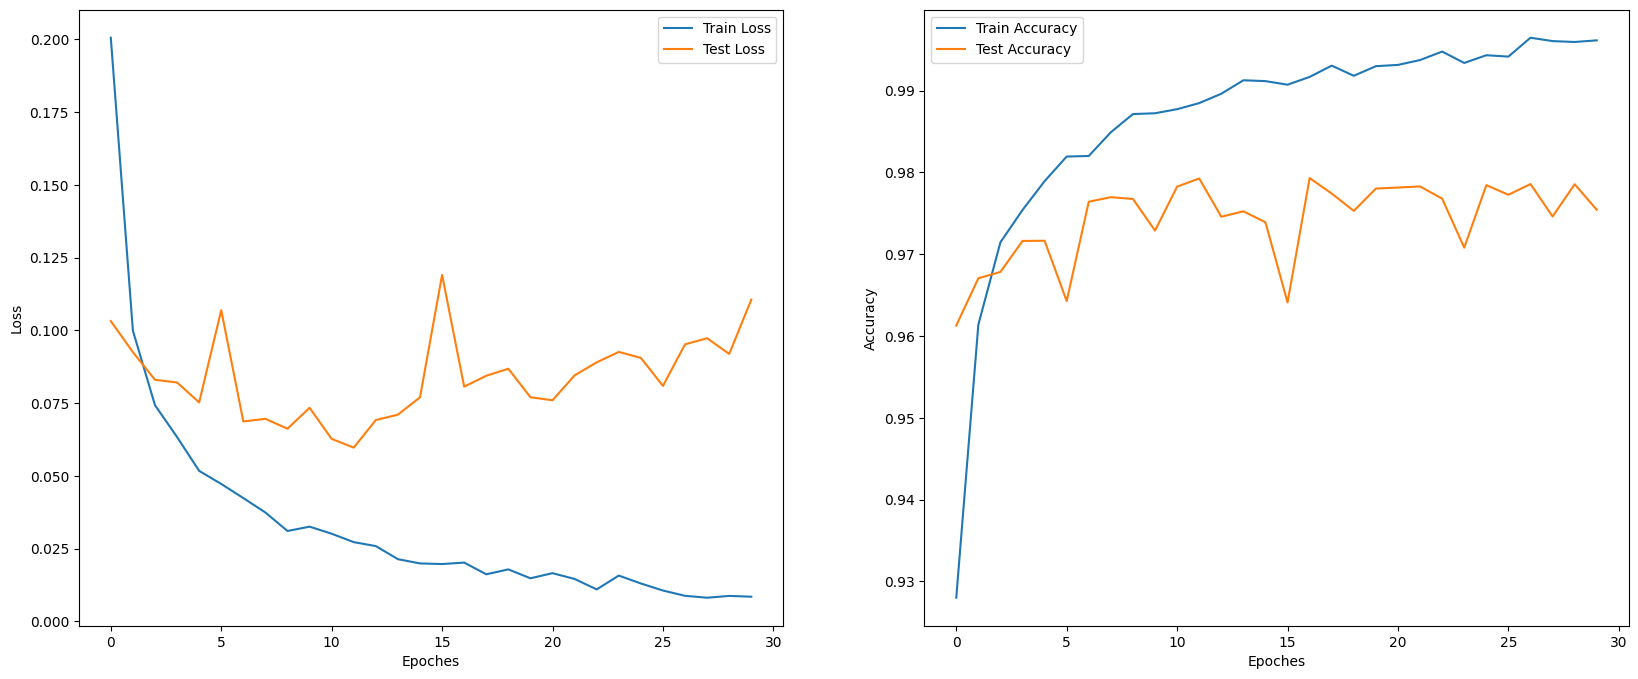

Execution time of 2 iter: 398.0965149140002 Seconds.


Train Accuracy,▁
Train Loss,▁
Validation Accuracy,▁
Validation Loss,▁
Train Accuracy,0.99614
Train Loss,0.00848
Validation Accuracy,0.97543
Validation Loss,0.11056


Current iter: 3/4
Activation function: RELU and Optimizer: Adam



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1972 | Test Loss: 0.1778 | Train Accuray: 0.9344 | Test Accuracy: 0.9432

Epoch: 2
Train Loss: 0.1092 | Test Loss: 0.0820 | Train Accuray: 0.9622 | Test Accuracy: 0.9717

Epoch: 3
Train Loss: 0.0902 | Test Loss: 0.0949 | Train Accuray: 0.9681 | Test Accuracy: 0.9671

Epoch: 4
Train Loss: 0.0999 | Test Loss: 0.3309 | Train Accuray: 0.9649 | Test Accuracy: 0.9161

Epoch: 5
Train Loss: 0.0745 | Test Loss: 0.1182 | Train Accuray: 0.9745 | Test Accuracy: 0.9573

Epoch: 6
Train Loss: 0.0631 | Test Loss: 0.0909 | Train Accuray: 0.9777 | Test Accuracy: 0.9736

Epoch: 7
Train Loss: 0.0732 | Test Loss: 0.0858 | Train Accuray: 0.9735 | Test Accuracy: 0.9707

Epoch: 8
Train Loss: 0.0577 | Test Loss: 0.0705 | Train Accuray: 0.9785 | Test Accuracy: 0.9746

Epoch: 9
Train Loss: 0.0465 | Test Loss: 0.0615 | Train Accuray: 0.9835 | Test Accuracy: 0.9793

Epoch: 10
Train Loss: 0.0532 | Test Loss: 0.0583 | Train Accuray: 0.9816 | Test Accuracy: 0.9791

Epoch: 11
Train Loss: 0.0504 

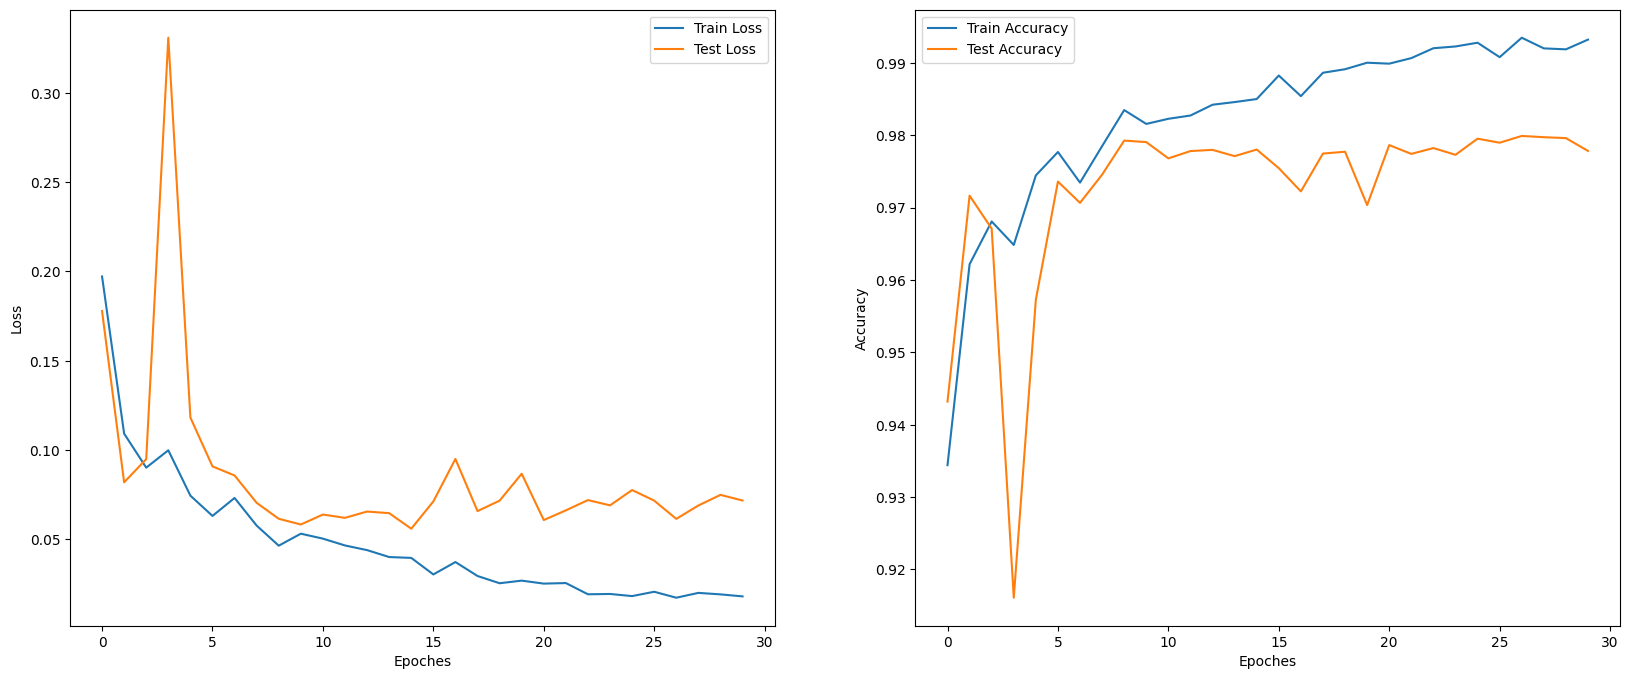

Execution time of 3 iter: 491.9555042820002 Seconds.


Train Accuracy,▁
Train Loss,▁
Validation Accuracy,▁
Validation Loss,▁
Train Accuracy,0.99324
Train Loss,0.01808
Validation Accuracy,0.97785
Validation Loss,0.07176


Current iter: 4/4
Activation function: RELU and Optimizer: SGD



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1992 | Test Loss: 0.1022 | Train Accuray: 0.9277 | Test Accuracy: 0.9650

Epoch: 2
Train Loss: 0.1011 | Test Loss: 0.0947 | Train Accuray: 0.9618 | Test Accuracy: 0.9671

Epoch: 3
Train Loss: 0.0759 | Test Loss: 0.0810 | Train Accuray: 0.9702 | Test Accuracy: 0.9675

Epoch: 4
Train Loss: 0.0664 | Test Loss: 0.1038 | Train Accuray: 0.9742 | Test Accuracy: 0.9685

Epoch: 5
Train Loss: 0.0524 | Test Loss: 0.0706 | Train Accuray: 0.9788 | Test Accuracy: 0.9720

Epoch: 6
Train Loss: 0.0454 | Test Loss: 0.0845 | Train Accuray: 0.9833 | Test Accuracy: 0.9717

Epoch: 7
Train Loss: 0.0418 | Test Loss: 0.0737 | Train Accuray: 0.9823 | Test Accuracy: 0.9736

Epoch: 8
Train Loss: 0.0361 | Test Loss: 0.0770 | Train Accuray: 0.9852 | Test Accuracy: 0.9743

Epoch: 9
Train Loss: 0.0330 | Test Loss: 0.0753 | Train Accuray: 0.9869 | Test Accuracy: 0.9735

Epoch: 10
Train Loss: 0.0317 | Test Loss: 0.0722 | Train Accuray: 0.9866 | Test Accuracy: 0.9775

Epoch: 11
Train Loss: 0.0292 

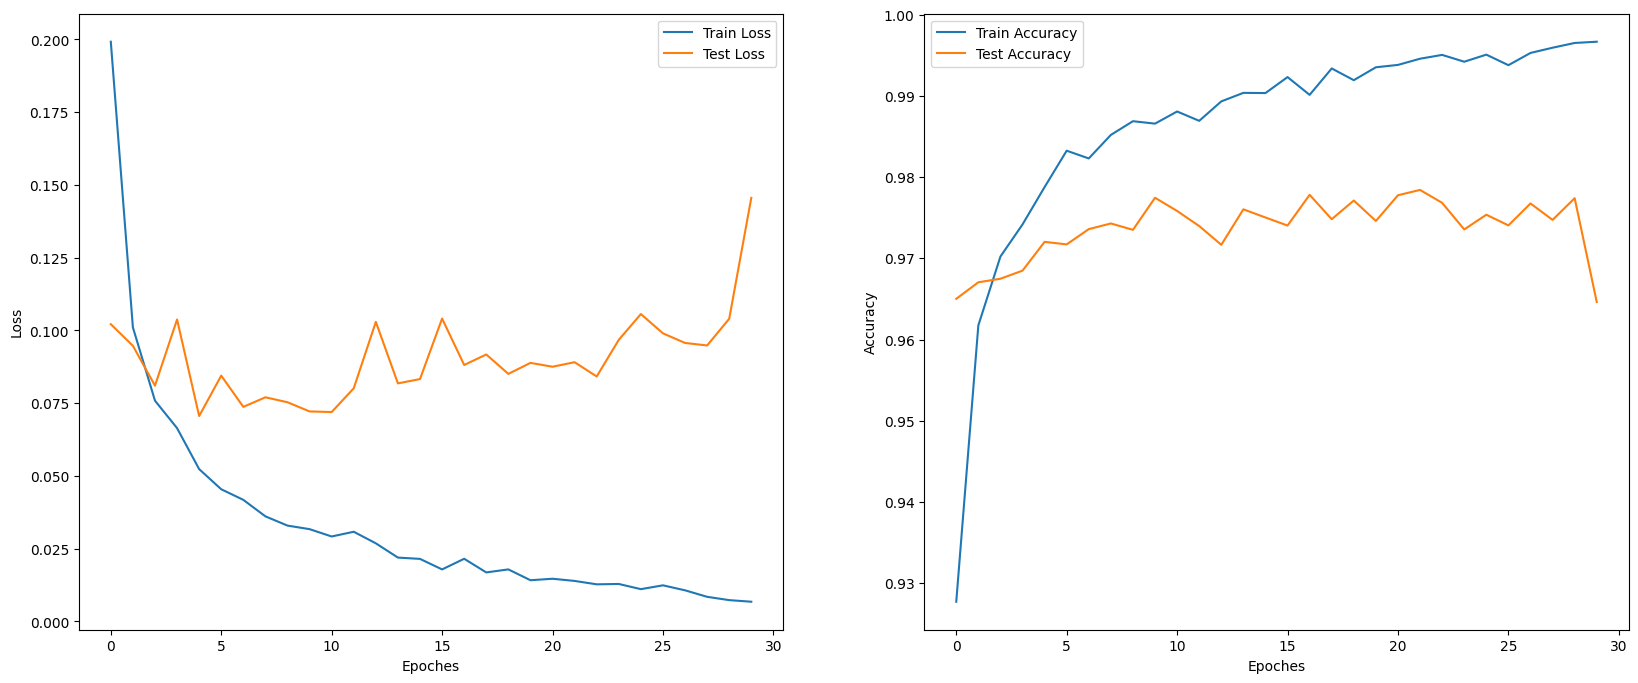

Execution time of 4 iter: 399.0964121699999 Seconds.


Train Accuracy,▁
Train Loss,▁
Validation Accuracy,▁
Validation Loss,▁
Train Accuracy,0.9967
Train Loss,0.00679
Validation Accuracy,0.96463
Validation Loss,0.14557


In [25]:
# init. epochs
epoches = 30

current, total_hy = 1, len(activation_function) * len(optimizer)


for h_p in hyper_para:
  print(f'Current iter: {current}/{total_hy}')
  print(f'Activation function: {h_p[0]} and Optimizer: {h_p[1]}')
  print()

  start_time = timer()

  model_18 = models.resnet18(weights = 'DEFAULT', progress = False)
  model_18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  feature_number = model_18.fc.in_features
  model_18.fc = nn.Linear(feature_number, len(class_names))
  model_18 = model_18.to(device)

  if h_p[0] == 'Tanh':
    # model_18 = nn.Sequential(*funct(list(model_18.children()))).to(device)
    for name,child in model_18.named_children():
      if isinstance(child,nn.ReLU) or isinstance(child,nn.Tanh):
          model_18._modules['relu'] = nn.Tanh()


  if h_p[1] == 'Adam':
    optim = torch.optim.Adam(params = model_18.parameters(), lr = 1e-3)
  else:
    optim = torch.optim.SGD(params = model_18.parameters(), lr = 1e-2)

  wandb.init(
        # set the wandb project where this run will be logged
        project="dlops-lab-assi-8",
        
        # track hyperparameters and run metadata
        config={
        "activation_function": h_p[0],
        "optimizer": h_p[1],
        "architecture": "Resnet18",
        "dataset": "FashionMNIST",
        "epochs": epoches,
        }
    )

  
  model_18_train_loss, model_18_test_loss = [], []
  model_18_train_accs, model_18_test_accs = [], []
  print()

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):
    print(f"Epoch: {epoch+1}")
    train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                      loss_fn = loss_fn, optimizer = optim,
                                      accuracy_fn = accuracy_fn, device = device)
    
    test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                    loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                    device = device)
    
    val_loss, accuracy = validate_model(model_18, test_dataloader, loss_fn, accuracy_fn, log_images=(epoch==(wandb.config.epochs-1)), device = device)
    
    model_18_train_loss.append(train_loss.item())
    model_18_test_loss.append(test_loss.item())
    model_18_train_accs.append(train_acc.item())
    model_18_test_accs.append(test_acc.item())


    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
    print()

  wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc, "Validation Loss": val_loss, "Validation Accuracy": accuracy})

  plot_graph(model_18_train_loss, model_18_test_loss, model_18_train_accs, model_18_test_accs)

  end_time = timer()

  print(f"Execution time of {current} iter: {end_time - start_time} Seconds.")

  wandb.finish()

  current += 1
  # save_model('cifair100_model_18.pth', model_18)
  # print("Model saved")